# Visualize the Attention of the Models

In [1]:
# transformer 

#path = "/nfs/home/sveng/logs/random_sharpe_transformer/11_06_2021/opt_a-transformer_l-sharpe_ty-2000_bs-64_lr-0.001_pa-25_gn-0.01_wl-63_ws-63_nl-3_dh-16_dr-0.4_dm-16_nh-2.p"

## 2020
path = "/nfs/home/sveng/logs/random_sharpe_transformer/11_06_2021/opt_a-transformer_l-sharpe_ty-2020_bs-128_lr-0.001_pa-25_gn-1_wl-63_ws-63_nl-2_dh-512_dr-0.1_dm-128_nh-4.p"

# standard scaler
## - 1995
#path = "/nfs/home/sveng/logs/random_sharpe_transformer/13_06_2021_scaler_standard/opt_a-transformer_l-sharpe_ty-1995_bs-64_lr-0.0001_pa-25_gn-0.1_wl-63_ws-63_nl-2_dh-16_dr-0.1_dm-16_nh-8.p"

## ~ - 2000
#path = "/nfs/home/sveng/logs/random_sharpe_transformer/13_06_2021_scaler_standard/opt_a-transformer_l-sharpe_ty-2000_bs-64_lr-0.001_pa-25_gn-0.01_wl-63_ws-63_nl-3_dh-32_dr-0.3_dm-16_nh-4.p"

## ~ - 2005

## ~ - 2010

## ~ - 2015

## ~ - 2020
#path = "/nfs/home/sveng/logs/random_sharpe_transformer/13_06_2021_scaler_standard/opt_a-transformer_l-sharpe_ty-2020_bs-128_lr-0.0001_pa-25_gn-0.1_wl-63_ws-63_nl-1_dh-32_dr-0.5_dm-16_nh-8.p"

In [1]:
# Informer

path = "/nfs/home/sveng/logs/random_sharpe_informer/08_06_2021_normal_emb/opt_a-informer_l-sharpe_ty-2020_bs-64_lr-0.001_pa-25_gn-0.1_wl-63_ws-63_nl-2_dh-32_dr-0.1_dm-32_nh-8_attn-prob_embed-fixed_factor-5.p"

In [2]:
import numpy as np
import pandas as pd
import pickle
import torch
from torch.utils.data import DataLoader
from libs.data_loader import BaseDataLoader, DataTypes
import matplotlib.pyplot as plt
import seaborn as sns

from libs.data_loader import BaseDataLoader, DataTypes
from libs.futures_dataset import FuturesDataset

## Load Model & Data

In [3]:
train_dict = pickle.load(open(path, 'rb'))
model = train_dict['model']
train_manager = train_dict['train_manager']

# --- ---

index_col = 0

base_loader = BaseDataLoader(
    filename=train_manager['args']['filename'], index_col=index_col, start_date=train_manager['args']['start_date'], end_date=train_manager['args']['end_date'], test_date=train_manager['args']['test_date'], lead_target=train_manager['args']['lead_target'])

dataset_train = FuturesDataset(
    base_loader, DataTypes.TRAIN, win_size=train_manager['args']['win_len'], tau=train_manager['args']['lead_target'], step=train_manager['args']['step'], scaler=train_manager['args']['scaler'])
dataset_test = FuturesDataset(
    base_loader, DataTypes.TEST, win_size=train_manager['args']['win_len'], tau=train_manager['args']['lead_target'], step=train_manager['args']['step'], scaler=train_manager['args']['scaler'])
test_dataloader = DataLoader(
    dataset_test, batch_size=train_manager['args']['batch_size'], shuffle=False)

> Load raw datset (futures_prop.csv)
> Filtered out series: 
> Winzorizing [3, 3, 3, 1, 1] values at:             [ZR_close, NR_close, ZO_close, ZP_close, BN_close] (threshold: 5)
> Calculate covariates
> No additional scaling used
> No additional scaling used


## Plot Predictions

LossTypes.SHARPE


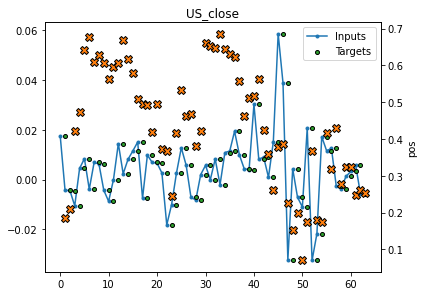

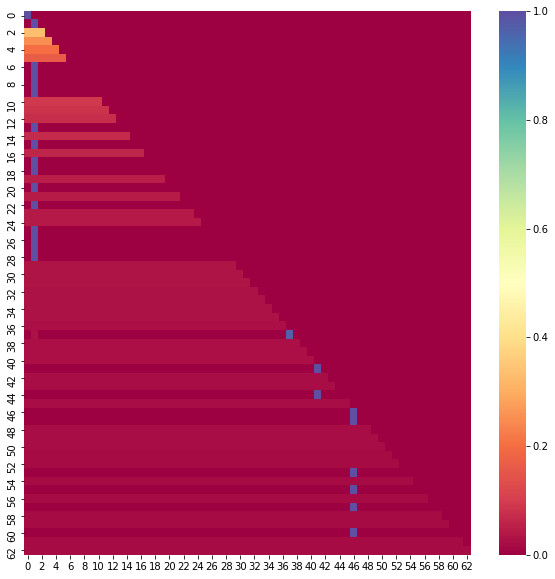

In [4]:
attn_i = dataset_test.plot_example(90, model=model, loss_type=train_manager['loss_type'])

## Visualize Attention

In [5]:
#attn = dataset_test.get_attention(id=1, model=model).cpu().numpy()[0, :, :, :]

attn = dataset_test.get_attention(id=1, model=model)

if isinstance(attn, list):
    # informer
    attn = attn[0].detach().cpu().numpy()[0, :, :, :]
else:
    # transformer
    attn = attn.detach().cpu().numpy()[0, :, :, :]

<AxesSubplot:>

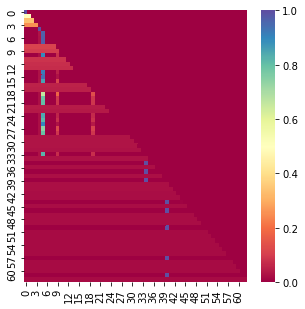

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(attn[0, :, :], ax=ax, cmap="Spectral")

In [7]:
def plot_attention_line(model, data_iter=dataset_test, base_df=base_loader.df[DataTypes.TEST], id=None, step=2, n_color=5, n_layer=0):
    if id is None:
        # randomize
        sample_size = len(data_iter)
        id = int(np.random.uniform(0, sample_size))
    
    attn = data_iter.get_attention(id=id, model=model)
    if isinstance(attn, list):
        # informer
        attn = attn[0].detach().cpu().numpy()[0, :, :, :]
    else:
        # transformer
        attn = attn.detach().cpu().numpy()[0, :, :, :]

    attn = attn / np.sum(attn)
    inst = dataset_test[id]['inst']

    # build df ----
    df_plot = pd.DataFrame({
        'prs': data_iter[id]['prs'][:, 0].squeeze().cpu().numpy(),
        'prs_lead': data_iter[id]['prs'][:, 1].squeeze().cpu().numpy(),
        'attn': np.flip(attn[n_layer, :, 0], axis=-1),
        't': data_iter[id]['time']
    })
    #df_plot['t'] = range(df_plot.shape[0])
    df_plot['date'] = base_df.index[df_plot['t']]
    df_plot['t_group'] = pd.qcut(df_plot['t'], int(63/step), labels=False)
    df_plot['attn_mean'] = df_plot['attn'].groupby(df_plot['t_group']).transform('mean')
    df_plot['attn_group'] = pd.qcut(df_plot['attn_mean'], n_color, labels=False)

    # plot ----
    fig, ax = plt.subplots(1,1)
    cmap = plt.get_cmap(name='viridis', lut=n_color)
    for i in range(0, 63+1, step):
        # ... in segments ----
        group = df_plot.iloc[i:(i+step+1),:]
        attn_i = group.iloc[0, -1]
        color = cmap(attn_i)
        ax.plot(group['date'], group['prs'], color=color, markeredgewidth=1.5, zorder=0, marker=".")
        ax.plot(group['date'], group['prs'], color=color, linewidth=2.5, zorder=2)

    # prediction point
    # ... currently not support business date (!)
    next_date = df_plot['date'].iat[-1] + pd.Timedelta(1, 'D')
    ax.scatter(next_date, df_plot['prs_lead'].iat[-1], marker="x", color="red")

    # raw
    ax2 = ax.twinx()
    ax2.plot(df_plot['date'], df_plot['attn'], '--', zorder=1, color="black")

    # labels, ..
    ax.set_xlabel('t')
    ax.set_ylabel('price')
    ax2.set_ylabel('attention')
    ax.set_title(inst)
    ax.tick_params(axis='x', rotation=70)
    fig.show()

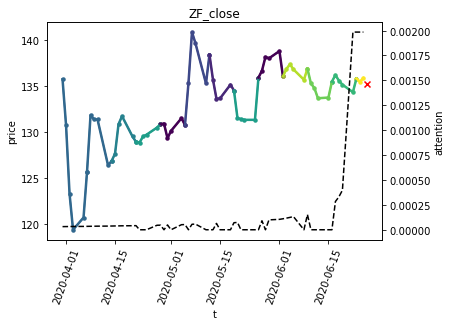

In [20]:
plot_attention_line(model=model, data_iter=dataset_test, step=5, n_color=10)

## Positional Attention (Global)

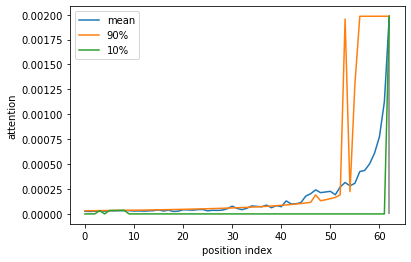

In [21]:
def calc_pos_attention(data_iter, model):
    attn_dict = {}

    for id in range(len(data_iter)):
        attn = data_iter.get_attention(id=id, model=model)
        if isinstance(attn, list):
            # informer
            attn = attn[0].detach().cpu().numpy()[0, :, :, :]
        else:
            # transformer
            attn = attn.detach().cpu().numpy()[0, :, :, :]
        attn = attn / np.sum(attn)

        # tmp: just look at last (& full) time window; first layer
        attn_last = attn[0, :, 0]

        attn_dict[id] = np.flip(attn_last, axis=-1)

    df = pd.DataFrame(attn_dict)
    return df

def plot_pos_attention(df):
    fig, ax = plt.subplots(1,1)
    ax.plot(range(df.shape[0]), df.mean(axis=1), label="mean")
    ax.plot(range(df.shape[0]), df.quantile(q=0.9, axis=1), label="90%")
    ax.plot(range(df.shape[0]), df.quantile(q=0.1,axis=1), label="10%")
    ax.vlines(df.shape[0]-1, ymin=0, ymax=np.max(df.mean(axis=1)), color="grey")
    #xlabels = {i: str(i - global_attn.shape[0]) for i in range(global_attn.shape[0]) if i % 5 == 0}
    #print(xlabels)
    #ax.set_xticks(xlabels.keys())
    #ax.set_xticklabels(xlabels.values())
    ax.legend()
    ax.set_ylabel("attention")
    ax.set_xlabel("position index")


pos_attention = calc_pos_attention(dataset_test, model)
plot_pos_attention(pos_attention)

## Regime identification Attention (Global)

In [22]:
data_iter = dataset_train
base_df = base_loader.df[DataTypes.TRAIN]

# ----

attn_dict = {}
for id in range(0, len(data_iter)):
    attn = data_iter.get_attention(id=id, model=model)
    if isinstance(attn, list):
        # informer
        attn = attn[0].detach().cpu().numpy()[0, :, :, :]
    else:
        # transformer
        attn = attn.detach().cpu().numpy()[0, :, :, :]
    attn = attn / np.sum(attn)
    
    inst = data_iter[id]['inst']
    ts = data_iter[id]['time'].detach().cpu().numpy()
    dates = base_df.index[ts]

    # tmp: just look at full window (last entry)
    attn_last = attn[0, :, 0]
    dates_last = dates[-1]

    if inst not in attn_dict:
        attn_dict[inst] = {}
    attn_dict[inst][dates_last] = attn_last

attn_touple = {(outerKey, innerKey): values for outerKey, innerDict in attn_dict.items() for innerKey, values in innerDict.items()}
df_attn = pd.DataFrame(attn_touple)
df_attn

AN_close                                                    \
      1990-03-29    1990-06-28 1990-09-25    1990-12-21 1991-03-22   
0   1.984127e-03  1.984127e-03   0.001984  1.984127e-03   0.001984   
1   9.920635e-04  7.614086e-09   0.001984  1.984078e-03   0.000992   
2   6.008239e-31  4.521047e-09   0.001984  1.983727e-03   0.000661   
3   4.381870e-36  5.014492e-09   0.001984  2.597283e-10   0.000496   
4   6.843885e-33  3.968254e-04   0.000397  1.179292e-10   0.000883   
..           ...           ...        ...           ...        ...   
58  3.362927e-05  3.362927e-05   0.000034  3.362927e-05   0.000034   
59  3.306878e-05  3.306878e-05   0.000033  2.636885e-15   0.000033   
60  3.252667e-05  3.252667e-05   0.000033  3.252667e-05   0.000033   
61  3.200205e-05  3.200205e-05   0.000032  3.200205e-05   0.000032   
62  3.149408e-05  6.722050e-15   0.000031  6.435254e-17   0.000031   

                                                                          ...  \
      1991-06-21    1991-09-18    1991-12-16    1992-03-16    1992-06-15  ...   
0   1.984127e-03  1.984127e-03  1.984127e-03  1.984127e-03  1.984127e-03  ...   
1   1.972248e-19  1.978390e-03  9.920635e-04  1.981471e-03  1.984127e-03  ...   
2   1.276924e-20  6.613757e-04  1.019367e-23  6.613757e-04  1.984127e-03  ...   
3   3.531047e-20  2.535322e-05  4.960317e-04  4.960317e-04  1.984127e-03  ...   
4   4.720679e-21  3.968254e-04  3.968254e-04  3.968254e-04  3.968254e-04  ...   
..           ...           ...           ...           ...           ...  ...   
58  3.362927e-05  3.362927e-05  3.362927e-05  3.362927e-05  5.961972e-08  ...   
59  3.306878e-05  3.306878e-05  3.306878e-05  3.306878e-05  2.955243e-08  ...   
60  3.252667e-05  3.252667e-05  3.252667e-05  3.252667e-05  3.252667e-05  ...   
61  3.200205e-05  1.408398e-18  3.200205e-05  6.642059e-22  2.855813e-08  ...   
62  3.149408e-05  3.149408e-05  3.149408e-05  3.149408e-05  3.149408e-05  ...   

        ZZ_close                                                       \
      2011-09-20    2011-12-16 2012-03-16    2012-06-13    2012-09-10   
0   1.984127e-03  1.984127e-03   0.001984  1.984127e-03  1.984127e-03   
1   1.984127e-03  1.984127e-03   0.001984  9.920635e-04  1.984127e-03   
2   6.613757e-04  1.109917e-03   0.001984  1.974365e-03  6.613757e-04   
3   3.066376e-15  1.207939e-03   0.000496  4.960317e-04  4.960317e-04   
4   3.968254e-04  9.678877e-04   0.000397  1.579504e-04  3.026789e-19   
..           ...           ...        ...           ...           ...   
58  3.362927e-05  3.362927e-05   0.000034  4.204637e-27  3.362927e-05   
59  3.306878e-05  3.306878e-05   0.000033  7.408388e-29  6.219205e-17   
60  3.252667e-05  3.252667e-05   0.000033  3.252667e-05  3.252667e-05   
61  3.200205e-05  3.200205e-05   0.000032  4.054877e-30  3.200205e-05   
62  3.149408e-05  3.447796e-19   0.000031  3.149408e-05  3.149408e-05   

                                                                          
      2012-12-06    2013-03-07    2013-06-04    2013-08-30    2013-11-27  
0   1.984127e-03  1.984127e-03  1.984127e-03  1.984127e-03  1.984127e-03  
1   1.622889e-07  9.920635e-04  9.920635e-04  1.073835e-18  1.937365e-06  
2   1.224928e-07  6.613757e-04  1.640951e-03  1.189425e-19  4.185610e-13  
3   4.960317e-04  4.960317e-04  1.774894e-03  1.846867e-21  4.960317e-04  
4   1.038364e-07  3.968254e-04  1.660487e-03  3.968254e-04  8.478629e-16  
..           ...           ...           ...           ...           ...  
58  3.362927e-05  2.225293e-19  7.186332e-21  3.362927e-05  3.362927e-05  
59  3.306878e-05  3.306878e-05  3.306878e-05  3.306878e-05  3.306878e-05  
60  1.192518e-24  3.252667e-05  3.252667e-05  3.252667e-05  3.252667e-05  
61  3.200205e-05  3.200205e-05  9.689206e-22  3.200205e-05  1.788258e-19  
62  3.149408e-05  3.149408e-05  1.445150e-20  1.619845e-25  3.149408e-05  

[63 rows x 4382 columns]

In [23]:
def calc_bhattacharyya_coef(p, q):
    '''Calculates the Byattacharyya distance of two histograms.'''
    def normalize(h):
        return h / np.sum(h)
    return np.sum(np.sqrt(np.multiply(normalize(p), normalize(q))))

def calc_distance(p, q):
    return np.sqrt(1 - calc_bhattacharyya_coef(p, q))

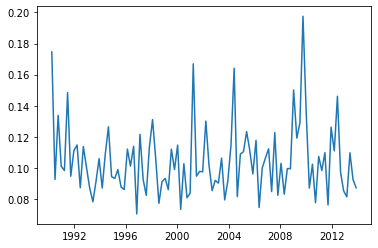

In [24]:

tmp = df_attn
tmp = tmp.T
tmp = tmp.reset_index(drop=False) 
tmp = tmp.groupby('level_1').mean() # average across instruments

# calc distance per t ----
tmp_avg = tmp.mean(axis=0)
list = {}
for i, date in enumerate(tmp.index):
    # per t
    list[date] = calc_distance(tmp.iloc[i,:], tmp_avg)

plt.plot(list.keys(), list.values())

0 ZN_close
1 SB_close
2 TY_close
3 AN_close


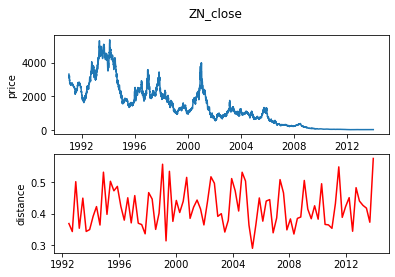

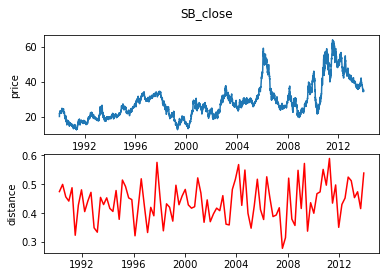

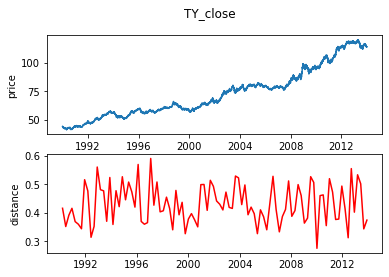

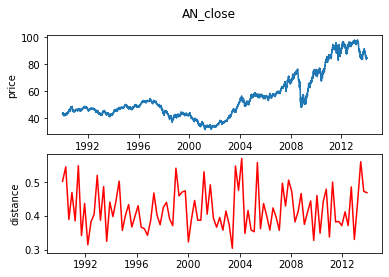

In [25]:
# Single Instrument

inst = 'ZN_close'

def plot_attn_distance_per_inst(inst_label, base_df, df_attn):
    prs_inst = base_df[inst_label]['prs']
    tmp_inst = df_attn[inst_label].T

    dists = {}
    for i, date in enumerate(tmp_inst.index):
        # per t
        dists[date] = calc_distance(tmp_inst.iloc[i,:], tmp_avg)

    fig, axes = plt.subplots(2,1)
    fig.suptitle(inst)
    axes[0].plot(prs_inst.index, prs_inst.values)
    axes[0].set_ylabel("price")
    axes[1].plot(dists.keys(), dists.values(), color="red")
    axes[1].set_ylabel("distance")


base_df = base_loader.df[DataTypes.TRAIN]
base_df.columns
insts = ['ZN_close', 'SB_close', 'TY_close', 'AN_close']
for i, inst in enumerate(insts):
    print(i, inst)
    plot_attn_distance_per_inst(inst_label=inst, base_df=base_df, df_attn=df_attn)


## Informer - TMP

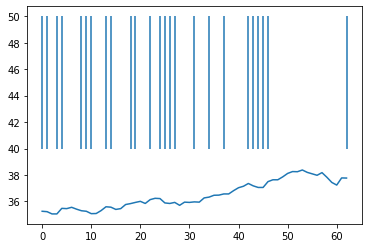

In [37]:
id = 50

attn = dataset_train.get_attention(id=id, model=model)
attn = attn[0].detach().cpu().numpy()[0, :, :, :]

prs = dataset_train[id]['prs'].detach().cpu().numpy()[:,0]

plt.plot(prs)
plt.vlines(np.arange(63)[attn[0, :, :].max(-1) > 0.4], ymin=40, ymax=50)

array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10, 12, 14, 15, 22, 24, 25, 26,
       28, 40, 41, 42, 43, 44, 47, 48, 49, 57, 58])